## yt: on-the fly coordinate interpolation with NearestNDInterpolator and callables 

yt : [INFO     ] 2023-06-13 14:12:41,275 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-06-13 14:12:41,277 Parameters: domain_dimensions         = [50 50 50]
yt : [INFO     ] 2023-06-13 14:12:41,279 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-06-13 14:12:41,280 Parameters: domain_right_edge         = [1.         6.28318531 3.14159265]
yt : [INFO     ] 2023-06-13 14:12:41,281 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-06-13 14:12:41,583 xlim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:12:41,585 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:12:41,586 Setting origin='native' for spherical geometry.
yt : [INFO     ] 2023-06-13 14:12:41,592 xlim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:12:41,593 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:12:41,610 Making a fixed resolution buffer of (('stream', 'neat')) 800 by 800



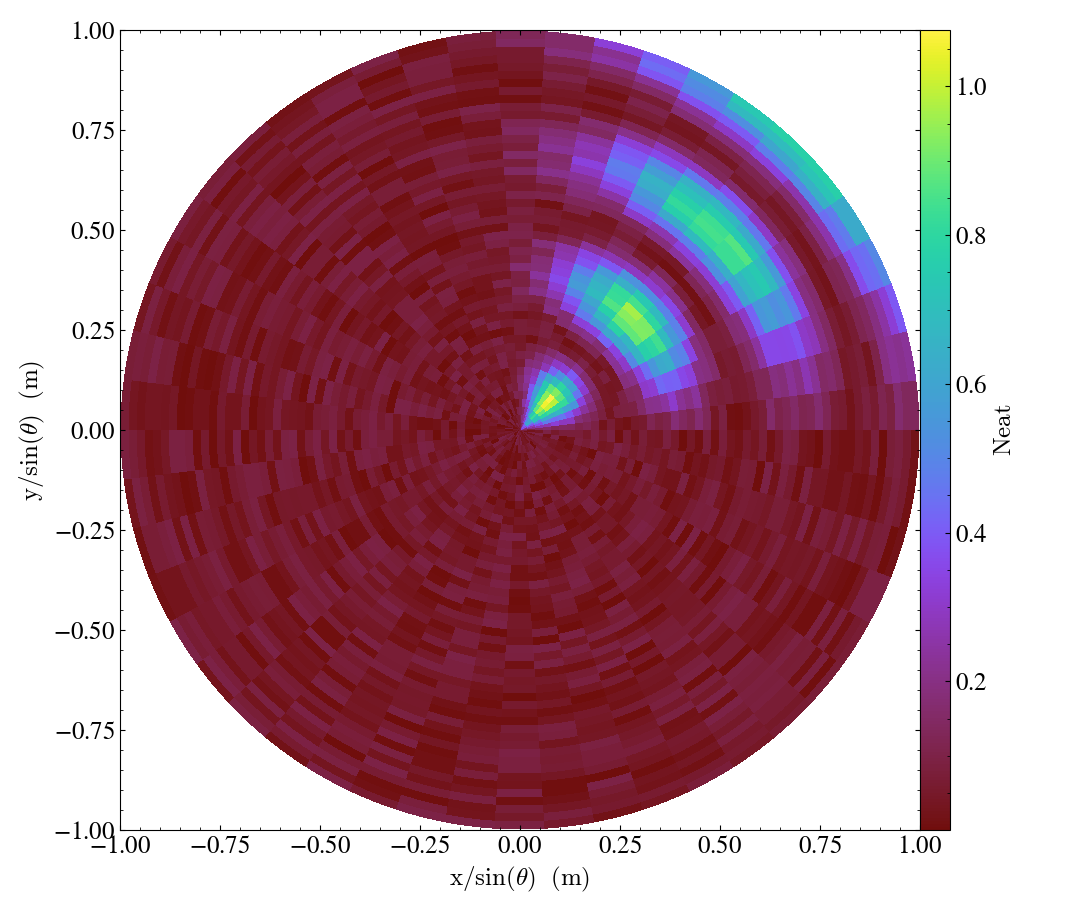

In [2]:
import yt 
import numpy as np 

bbox = np.array([[0., 1.], [0.0, 2 * np.pi], [0, np.pi]])
sz = (50, 50, 50) 
fake_data = {"density": np.random.random(sz)}

def _neato(field, data):
    r = data["index", "r"].d
    theta = data["index", "theta"].d
    phi = data["index", "phi"].d
    phi_c = 0.25 * np.pi
    theta_c = 0.5 * np.pi

    # decay away from phi_c, theta_c
    fac = np.exp(-(((phi_c - phi) / 0.5) ** 2)) * np.exp(
        -(((theta_c - theta) / 0.5) ** 2)
    ) 
    
    # cos^2 variation in r with slight increase towards rmin
    rfac = np.cos((r - 0.1) / 0.9 * 3 * np.pi) ** 2 * (1 - 0.25 * (r - 0.1) / 0.9)
    field = fac * rfac + 0.1 * np.random.random(r.shape)

    # field = field * (theta <= 2.0) * (phi < 1.25)
    return field


yt.add_field(
    name=("stream", "neat"),
    function=_neato,
    sampling_type="local",
    units="",
    force_override=True,
    take_log=False,
)

ds = yt.load_uniform_grid(
    fake_data,
    sz,
    bbox=bbox,
    nprocs=256,
    geometry="spherical", 
    axis_order =("r", "phi", "theta"),
    length_unit="m",
)
yt.SlicePlot(ds, "theta", ("stream", "neat"))

In [90]:
from scipy.interpolate import NearestNDInterpolator

def _get_cartesian_neat(grid, field_name):
    
    # get the target x, y, z in the new cartesian dataset
    x = grid[('index', 'x')]
    y = grid[('index', 'y')]
    z = grid[('index', 'z')]
    
    # extract original 
    ad = ds.all_data()  # THE SPHERICAL DATASET HANDLE!
    xi = ad[('index', 'cartesian_x')]
    yi = ad[('index', 'cartesian_y')]
    zi = ad[('index', 'cartesian_z')]
    neat_raw = ad[('stream', 'neat')]

    # interpolate
    interpolator = NearestNDInterpolator(np.column_stack((xi, yi, zi)), neat_raw)

    new_vals = interpolator(x.ravel(), y.ravel(), z.ravel()).reshape(x.shape)
    return new_vals

In [13]:
data = {'interpd_neat': _get_cartesian_neat}

In [60]:
def _neato(field, data):
    gn = data[("stream", "interpd_neat")]
    
    x = data[('index', 'x')]
    y = data[('index', 'y')]
    z = data[('index', 'z')]
    r = np.sqrt(x**2 + y**2 + z**2)
    
    gn[r>1.] = 0.0
    return gn 


yt.add_field(
    name=("stream", "neat"),
    function=_neato,
    sampling_type="local",
    units="",
    force_override=True,
    take_log=False,
)

yt : [INFO     ] 2023-06-13 14:15:40,394 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-06-13 14:15:40,396 Parameters: domain_dimensions         = [50 50 50]
yt : [INFO     ] 2023-06-13 14:15:40,398 Parameters: domain_left_edge          = [-1. -1. -1.]
yt : [INFO     ] 2023-06-13 14:15:40,399 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-06-13 14:15:40,401 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-06-13 14:15:40,865 xlim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:15:40,866 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:15:40,872 xlim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:15:40,872 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:15:40,878 Making a fixed resolution buffer of (('stream', 'neat')) 800 by 800



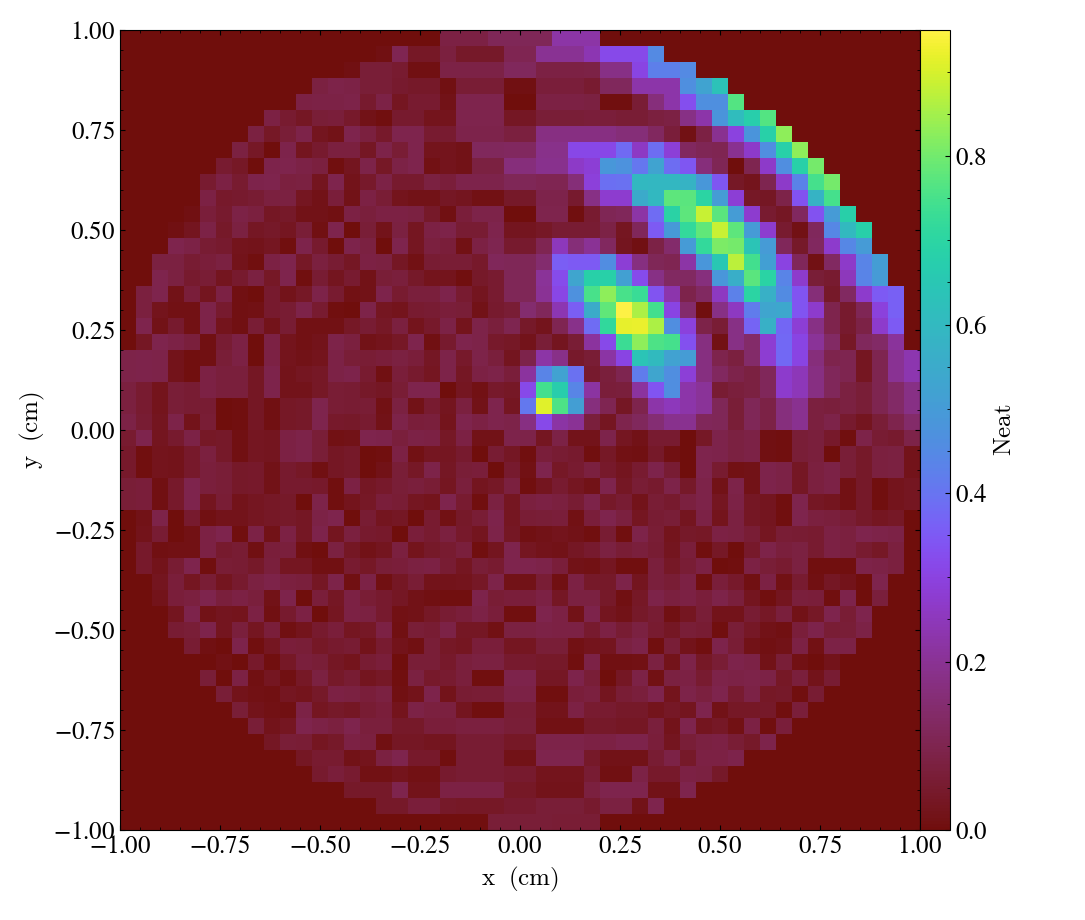

In [16]:

desired_shape = (50, 50, 50)
ds_3 = yt.load_uniform_grid(data, desired_shape, bbox=np.array([[-1, 1], [-1, 1], [-1, 1]]))
yt.SlicePlot(ds_3, "z", ("stream", "neat"))

yt : [INFO     ] 2023-06-13 14:15:48,301 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-06-13 14:15:48,304 Parameters: domain_dimensions         = [150 150 150]
yt : [INFO     ] 2023-06-13 14:15:48,306 Parameters: domain_left_edge          = [-1. -1. -1.]
yt : [INFO     ] 2023-06-13 14:15:48,309 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-06-13 14:15:48,309 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-06-13 14:15:54,295 xlim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:15:54,296 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:15:54,302 xlim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:15:54,302 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:15:54,308 Making a fixed resolution buffer of (('stream', 'neat')) 800 by 800



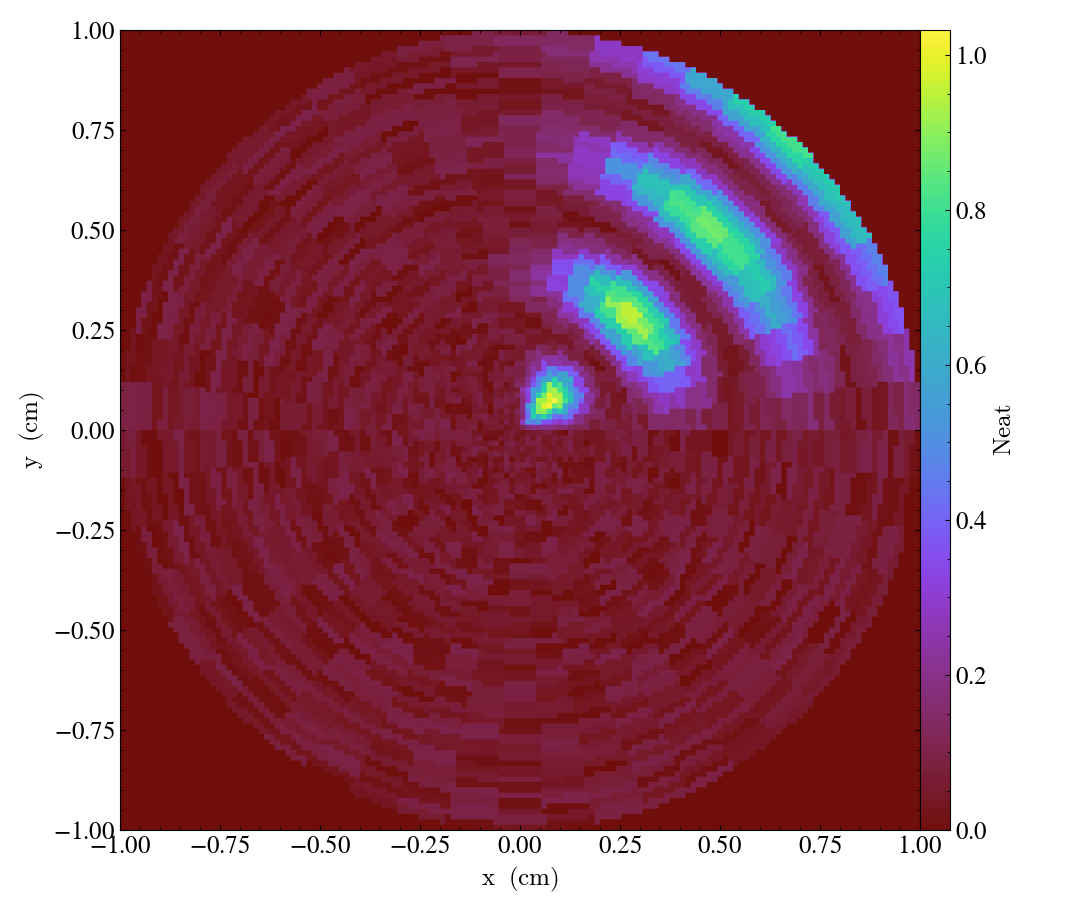

In [17]:
desired_shape = (150, 150, 150)
ds_3 = yt.load_uniform_grid(data, desired_shape, bbox=np.array([[-1, 1], [-1, 1], [-1, 1]]))
yt.SlicePlot(ds_3, "z", ("stream", "neat"))

## splitting into sub-grids 

Instead, use `load_amr_grids` and limit the interpolator by the desired coordinate ranges of each grid, so we only build the interpolator from more relevant coordinate ranges. 

yt : [INFO     ] 2023-06-13 14:28:38,109 hello


In [105]:
def _get_cartesian_neat(grid, field_name):
    
    # get the target x, y, z in the new cartesian dataset
    
    dxyz = ds.quan(0., 'code_length') # might want some slop
    grid_bbox = [ [grid.LeftEdge[idim]-dxyz, grid.RightEdge[idim]+dxyz] for idim in range(3)]
    
    # select subset of the domain in the original spherical dataset based on current
    # grid range
    conditionals = [f"obj[('index', 'cartesian_x')] <= {grid_bbox[0][1].d}",
                    f"obj[('index', 'cartesian_x')] >= {grid_bbox[0][0].d}",
                    f"obj[('index', 'cartesian_y')] <= {grid_bbox[1][1].d}",
                    f"obj[('index', 'cartesian_y')] >= {grid_bbox[1][0].d}",
                    f"obj[('index', 'cartesian_z')] <= {grid_bbox[2][1].d}",
                    f"obj[('index', 'cartesian_z')] >= {grid_bbox[2][0].d}",
                   ]
    cut_region = ds.cut_region(ds.all_data(), conditionals)
    xi = cut_region[('index', 'cartesian_x')]
    yi = cut_region[('index', 'cartesian_y')]
    zi = cut_region[('index', 'cartesian_z')]
    neat_raw = cut_region[('stream', 'neat')]
    
    # interpolate!
    print(f"interpolator constructed with {neat_raw.size} points")
    interpolator = NearestNDInterpolator(np.column_stack((xi, yi, zi)), neat_raw)

    x = grid[('index', 'x')]
    y = grid[('index', 'y')]
    z = grid[('index', 'z')]
    new_vals = interpolator(x.ravel(), y.ravel(), z.ravel()).reshape(x.shape)
    return new_vals

In [106]:
grid_data = [
  dict(
      left_edge=[-1.0, -1.0, -1.0],
      right_edge=[1.0, 1.0, 1.0],
      level=0,
      dimensions=[32, 32, 32],
  ),
     dict(
         left_edge=[0., 0., 0.],
         right_edge=[0.75, 0.75, 0.75],
         level=1,
         dimensions=[32, 32, 32],
     ),
    dict(
         left_edge=[-.25, -0.25, -0.25],
         right_edge=[0.25, 0.25, 0.25],
         level=2,
         dimensions=[32, 32, 32],
     ),
 ]

for g in grid_data:
    g[("stream", "interpd_neat")] = _get_cartesian_neat


bbox = np.array([[-1, 1], [-1, 1], [-1, 1]])
ds3 = yt.load_amr_grids(grid_data, [32, 32, 32], length_unit=1.0, bbox = bbox)   

yt : [INFO     ] 2023-06-13 15:09:22,733 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-06-13 15:09:22,735 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2023-06-13 15:09:22,737 Parameters: domain_left_edge          = [-1. -1. -1.]
yt : [INFO     ] 2023-06-13 15:09:22,739 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-06-13 15:09:22,740 Parameters: cosmological_simulation   = 0


interpolator constructed with 125000 points
interpolator constructed with 13137 points


yt : [INFO     ] 2023-06-13 15:09:23,923 xlim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 15:09:23,924 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 15:09:23,930 xlim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 15:09:23,931 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 15:09:23,938 Making a fixed resolution buffer of (('stream', 'neat')) 800 by 800


interpolator constructed with 37344 points



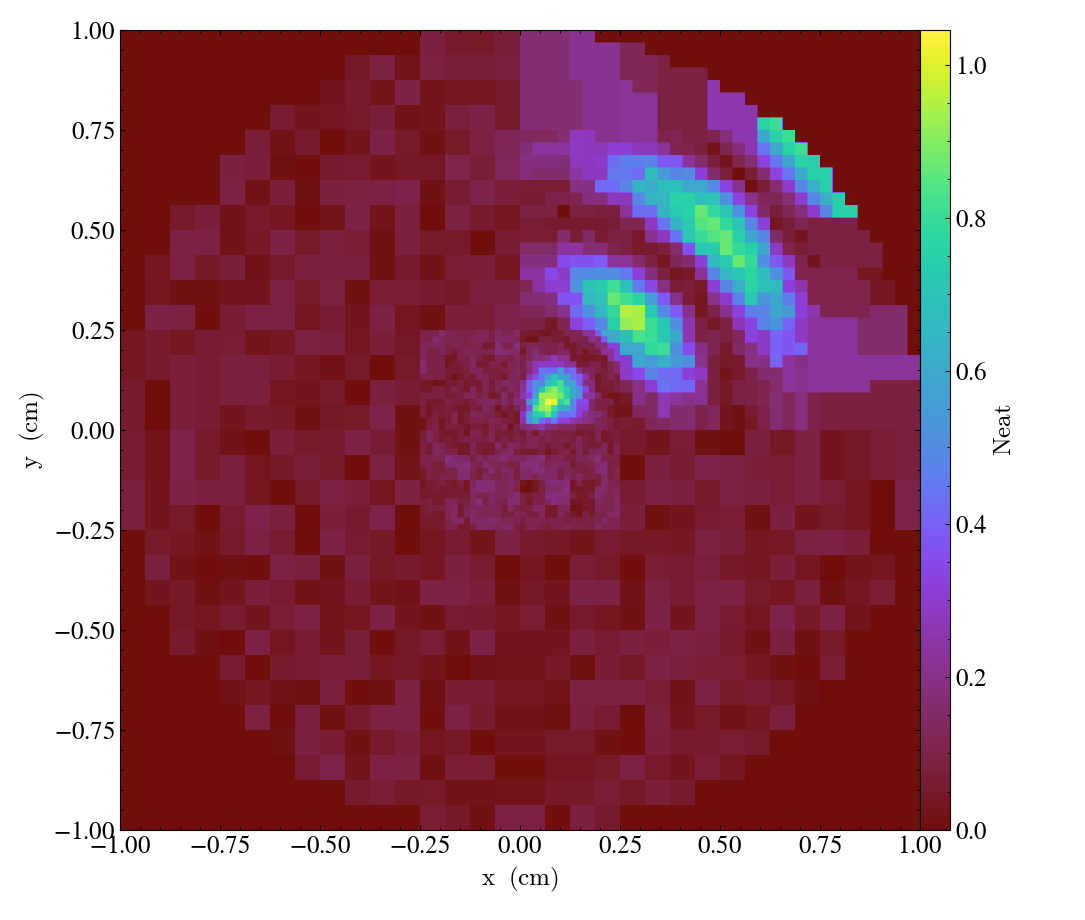

In [107]:
yt.SlicePlot(ds3, "z", ("stream", "neat"))